In [1]:
using Random
using DataStructures
using Plots
using Statistics

using NBInclude
@nbinclude("dcj_algo.ipynb")
@nbinclude("testing_diameter.ipynb")
# @nbinclude("testing_maps.ipynb")

In [2]:
# returns dup char --> num instances dictionary, num of duplicate chars  
##### returns 2 x N array (N = num dup char) of duplicate char & num instances, num of duplicate chars

function find_dups_in_str(str::String)
    alphabet = Set{Char}() 
    duplicates = OrderedDict{Char, Int}()  # duplicate char --> num instances 

    for char in str
        if char == '.' || char == ','
            continue 
        end 
        
        char = lowercase(char)   
        if char in alphabet 
            if char in keys(duplicates)
                duplicates[char] += 1
            else 
                duplicates[char] = 2 
            end 
        else 
            push!(alphabet, char)
        end 
    end 

    return duplicates, length(duplicates) 
end 

find_dups_in_str (generic function with 1 method)

In [3]:
function generate_map(num_dups::Int, dup_to_num_instances::OrderedDict{Char, Int}, S_M_set::Set{Array{Int}})
    while true 
        map = Array{Int}(undef, num_dups)
        
        idx = 1
        # for each position of the map (each gene w >1 instances)
        for (dup_char, num_instances) in pairs(dup_to_num_instances)
            # an integer value is selcted uniformly from the interval [0, occ(α, S)! -1] 
            mapidx_for_dup_char = rand(1:factorial(num_instances))
            
            map[idx] = mapidx_for_dup_char
            idx += 1
        end 
        if map ∉ S_M_set
            return map 
        end 
    end 
end 

# S = "aabc"
# S_dupchar_to_multiplicity, S_num_dups = find_dups_in_str(S)
# S_M_set = Set{Array{Int}}()
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
# push!(S_M_set, map)
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
# push!(S_M_set, map)
# map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set) # should throw error bc alr generated all possible maps

generate_map (generic function with 1 method)

In [4]:
# DP implementation of factorial
function Base.factorial(n::Int, factorials::Vector{Int})
    if n == 1 || n == 0 
        return 1
    end 

    if factorials[n] != 0  
        return factorials[n]
    else 
        fact =  n * factorial(n - 1, factorials)
        factorials[n] = fact
        return fact
    end 
end

# returns kth lexicogrpahical order of the first n ints 
# k ε [1,n!]
function nth_lex_permutation(n::Int, k::Int)
    k -= 1
    factorials = zeros(Int, 26)
        
    numbers = collect(1:n)
    permutation = Vector{Int}()

    for i in 1:n
        fact = factorial(n - i, factorials)
        index = div(k, fact)
        k %= fact

        push!(permutation, numbers[index+1])
        splice!(numbers, index+1)

    end
    
    return permutation
end


# n = 5  # num duplicates 
# k = 45  #  kth lexicogrpahical order of the first n ints [1:n!]

# perm = nth_lex_permutation(n, k)
# println(perm)

nth_lex_permutation (generic function with 1 method)

In [5]:
function new_char(alphabet::Set{Char})
    while length(alphabet) != 26 
        c = Char(rand('a':'z'))
        if c ∉ alphabet 
            push!(alphabet, c)
            return c
        end 
    end 
    throw(ArgumentError("Ran out of unique characters in the alphabet"))
    
end 

function convert_perm_to_ordered_unique_chars(dupchar::Char, dup_perm::Vector{Int}, dupchar_to_unique_char::Dict{Char, Vector{Char}})
    ordered_unique_chars = Vector{Char}()
    for i in dup_perm 
        push!(ordered_unique_chars, dupchar_to_unique_char[dupchar][i])
    end 
    return ordered_unique_chars
end 

function deduplicate_genome(map::Array{Int}, dup_genome::String, dupchar_to_multiplicity::OrderedDict{Char, Int}, dupchar_to_unique_char::Dict{Char, Vector{Char}})
    if dupchar_to_unique_char == Dict{Char, Vector{Char}}()  # passed in target genome; need to assign dup chars to unique chars
        alphabet = Set(dup_genome)
        
        # create mapping from duplicated chars (multiplicity k) --> [array of k unique chars], idx = idx of duplicate (referenced by permutation) 
        idx = 1
        for (dupchar, mult) in pairs(dupchar_to_multiplicity)
            unique_chars = [dupchar]
            for i in 2:dupchar_to_multiplicity[dupchar]
                c = new_char(alphabet)
                push!(unique_chars, c)
            end     
            dupchar_to_unique_char[dupchar] = unique_chars
            
            idx += 1
        end 
    end 
    
    # for each duplicated char, create the correct ordering of unique chars in deduplicated genome 
    # based on mapping from dup chars -> unique chars & lexicographical permutation
    idx = 1
    perm_to_ordered_unique_chars = Dict{Char, Vector{Char}}()
    for (dupchar, mult) in pairs(dupchar_to_multiplicity)
        # for each elem i in map, convert i --> ith permutation of k ints in lexicographical order (k = multiplicity) 
        dup_perm = nth_lex_permutation(mult, map[idx])  

        perm_to_ordered_unique_chars[dupchar] = convert_perm_to_ordered_unique_chars(dupchar, dup_perm, dupchar_to_unique_char)
        
        idx += 1
    end 

    # deduplicate the genome with the orderings generated above with the permutations for duplicate genes
    dedup_genome = Vector{Char}()
    for char in dup_genome
        
        if lowercase(char) in keys(dupchar_to_multiplicity)
            unique_char = perm_to_ordered_unique_chars[lowercase(lowercase(char))][1]
            if isuppercase(char) 
                unique_char = uppercase(unique_char)
            end 
            push!(dedup_genome, unique_char)

            splice!(perm_to_ordered_unique_chars[lowercase(char)], 1)
        else 
            push!(dedup_genome, char)
        end 
    end

    return join(dedup_genome)
end 


# P = "abbAac"
# P_dup_to_num_instances, P_num_dups = find_dups_in_str(P)
# P_map = generate_map(P_num_dups, P_dup_to_num_instances)
# dupchar_to_unique_char = Dict{Char, Vector{Char}}()

# deduplicate_genome(P_map, P, P_dup_to_num_instances, dupchar_to_unique_char)

deduplicate_genome (generic function with 1 method)

In [6]:
function linear_circ_helper(src_chroms::Vector{SubString{String}}) 
    linear_chroms = Vector{String}() 
    circ_chroms = Vector{String}()
    linear_idx_to_genome_idx = Dict{Int, Int}() 
    circ_idx_to_genome_idx = Dict{Int, Int}() 

    genome_idx = 1
    linear_idx = 1
    circ_idx = 1
    
    for c in src_chroms
        if c[1] == '.' 
            push!(linear_chroms, c)
            linear_idx_to_genome_idx[linear_idx] = genome_idx
            linear_idx += 1
        else 
            push!(circ_chroms, c)
            circ_idx_to_genome_idx[circ_idx] = genome_idx
            circ_idx += 1
        end 
        genome_idx += 1
    end 

    return linear_chroms, circ_chroms, linear_idx_to_genome_idx, circ_idx_to_genome_idx
end 


# insert random dup gene into the source string at a random location 
function randomly_insert_gene(src_chroms::Vector{SubString{String}}, rand_dup_gene::Char, alone::Bool, linear::Bool)   
    if alone 
        rand_idx = rand(1:length(src_chroms))
        if linear
            rand_dup_gene = "." * rand_dup_gene * "."
        end 
        insert!(src_chroms, rand_idx, string(rand_dup_gene))
        src = join(src_chroms, ",")

    else 
        linear_chroms, circ_chroms, linear_idx_to_genome_idx, circ_idx_to_genome_idx = linear_circ_helper(src_chroms)
       
        if linear # find all the linear chroms and choose one randomly to insert into 
            if linear_chroms == Vector{String}()   # no linear chroms
                # choose random index of genome and insert new linear chrom 
                rand_dup_gene = "." * rand_dup_gene * "."
                rand_idx = rand(1:length(src_chroms)+1)
                insert!(src_chroms, rand_idx, string(rand_dup_gene))
                src = join(src_chroms, ",")

            else  # randomly insert into existing linear chrom 
                rand_idx_lin_chroms = rand(1:length(linear_chroms))
                rand_idx_genome = linear_idx_to_genome_idx[rand_idx_lin_chroms]
                lin_chrom = linear_chroms[rand_idx_lin_chroms] 

                rand_idx_chrom = rand(2:length(lin_chrom))
                updated_chrom = lin_chrom[1:rand_idx_chrom-1] * string(rand_dup_gene) * lin_chrom[rand_idx_chrom:end]
                
                src_chroms[rand_idx_genome] = updated_chrom
                src = join(src_chroms, ",")
            end 

        else  # find all the circular chroms and choose one randomly to insert it into 
            if circ_chroms == Vector{String}()   # no circ chroms
                # choose random index of genome and insert new circ chrom 
                rand_idx = rand(1:length(src_chroms)+1)
                insert!(src_chroms, rand_idx, string(rand_dup_gene))
                src = join(src_chroms, ",")

            else  # randomly insert into existing linear chrom 
                rand_idx_circ_chroms = rand(1:length(circ_chroms))
                rand_idx_genome = circ_idx_to_genome_idx[rand_idx_circ_chroms]
                circ_chrom = circ_chroms[rand_idx_circ_chroms] 

                rand_idx_chrom = rand(1:length(circ_chrom)+1)
                updated_chrom = circ_chrom[1:rand_idx_chrom-1] * string(rand_dup_gene) * circ_chrom[rand_idx_chrom:end]
                
                src_chroms[rand_idx_genome] = updated_chrom
                src = join(src_chroms, ",")
            end 
        end 
    end  

    return src
end 


function generate_source_genome_with_xdup(n::Int, dup_genes:: Vector{Char})
    src = generate_genome_str(n)
    src_chroms = split(src, ",")
    
    for rand_dup_gene in dup_genes
        alone = rand(Bool)
        linear = rand(Bool)

        src = randomly_insert_gene(src_chroms, rand_dup_gene, alone, linear)
    end 
 
    return src
end 

function check_src_tar_balanced(src::String, target::String)
    num_genes_src = 0
    num_genes_tar = 0
    for g in src 
        if g == '.' || g == ','
            continue 
        end 
        num_genes_src += 1
    end 
    for g in target 
        if g == '.' || g == ','
            continue 
        end 
        num_genes_tar += 1
    end 
    
    if num_genes_src != num_genes_tar
        throw(ArgumentError("src and target from generate_genomes_with_xdup function aren't balanced"))
    end 
    
end 

# generates target and source genomes that contain the first n letters and adds x duplicate letters 
# x >= 1
function generate_genomes_with_xdup(n::Int, x::Int)
    # target 
    genes = first_n_letters(n)
    dup_genes = Vector{Char}()
    
    for i in 1:x
        rand_dup_gene = genes[rand(1:length(genes))]
        rand_idx = rand(1:length(genes)+1)
        insert!(genes, rand_idx, rand_dup_gene)
        push!(dup_genes, rand_dup_gene)
    end 
    target = join(genes)

    # source 
    src = generate_source_genome_with_xdup(n, dup_genes)

    check_src_tar_balanced(src, target)

    return src, target
end 

# generate_genomes_with_xdup(5, 2)

generate_genomes_with_xdup (generic function with 1 method)

In [13]:
# mapping S --> T, generates r random maps (RM)
# mode options: "none", "info"
function randommap(S::String, P::String, num_maps::Int, mode::String)
    if mode == "info"
        m = 1
    else  # none 
        m = 0 
    end 

    println("SRC ", S, " --> TARGET ", P, "\n")


    ## GENERATE MAPS  
    P_dupchar_to_multiplicity, P_num_dups = find_dups_in_str(P)
    S_dupchar_to_multiplicity, S_num_dups = find_dups_in_str(S)

    P_map = ones(Int, P_num_dups)

    if m >= 1
        printstyled("target", color=:magenta)
        println("\ndup genes --> multiplicity")
        println(P_dupchar_to_multiplicity, "\n")

        # arbitrary map p for target string 
        println("target map")
        print(P_map, "\n")
    end   
    
    # source maps 
    max_maps = 0 
    for (dup, num_instances) in S_dupchar_to_multiplicity
        max_maps += factorial(num_instances)
    end 

    if num_maps > max_maps
        num_maps = max_maps 
        println("\nWARNING: Number of maps exceeds max number of possible unique maps for source genome --> capping at ", max_maps)
    end 

    S_M = Array{Array{Int}}(undef, num_maps)  
    S_M_set = Set{Array{Int}}()


    # r RM of src str S are generated and stored in a set S_M 
    if m >= 1
        printstyled("\nsource", color=:magenta)
        println("\ndup genes --> multiplicity")
        println(S_dupchar_to_multiplicity, "\n")
        println("source maps")
    end 
    for i in 1:num_maps
        s_map = generate_map(S_num_dups, S_dupchar_to_multiplicity, S_M_set)
        S_M[i] = s_map
        push!(S_M_set, s_map)
        if m >= 1
            println(s_map)
        end 
    end 


    ## DEDUPICATION 
    if m >= 1
        printstyled("\ndeduplication\n", color=:magenta)
    end 
    dupchar_to_unique_char = Dict{Char, Vector{Char}}()

    P_dedup = deduplicate_genome(P_map, P, P_dupchar_to_multiplicity, dupchar_to_unique_char)
    if m >= 1
        println("deduplicated target ", P_dedup, "\n")
    end 

    S_dedup_list = Vector{String}()

    for s_map in S_M 
        s_dedup = deduplicate_genome(s_map, S, S_dupchar_to_multiplicity, dupchar_to_unique_char)
        push!(S_dedup_list, s_dedup)

        if m >= 1
            println("deduplicated source ", s_dedup)
        end 
    end 

    ## DCJ DISTANCE 
    dcj_dist_list = Vector{Int}()
    for s_dedup in S_dedup_list
        d = calculate_distance(P_dedup, s_dedup, "none")
        push!(dcj_dist_list, d)
    end

    print("\ndcj distances ", dcj_dist_list)
    return dcj_dist_list
    # return shortest map iwth shortest dist between permutations 
end 


# src = "aaAAaAbbbBbbccd"  # 6a, 6b, 2c, 1d
# target = "abcdabbaacbabab"
# num_maps = 100

# src = ".a.,aab,bc"  
# target = "ba,a,b,ca"
# num_maps = 8

n = 5
x = 5
src, target = generate_genomes_with_xdup(n, x)

num_maps = 10

dcj_dist_list = randommap(src, target, num_maps, "info")

SRC b,.bde.,.b.,b,.e.,.a.,.e.,.c. --> TARGET abebcbedeb

target
dup genes --> multiplicity
OrderedDict('b' => 4, 'e' => 3)

target map
[1, 1]

source
dup genes --> multiplicity
OrderedDict('b' => 4, 'e' => 3)

source maps
[7, 2]
[13, 5]
[2, 2]
[19, 2]
[23, 3]
[4, 3]
[4, 1]
[16, 6]
[2, 5]
[16, 2]

deduplication
deduplicated target abencytdqf

deduplicated source n,.bde.,.y.,f,.q.,.a.,.t.,.c.
deduplicated source y,.bdq.,.n.,f,.e.,.a.,.t.,.c.
deduplicated source b,.nde.,.f.,y,.q.,.a.,.t.,.c.
deduplicated source f,.bde.,.n.,y,.q.,.a.,.t.,.c.
deduplicated source f,.ydt.,.b.,n,.e.,.a.,.q.,.c.
deduplicated source b,.ydt.,.f.,n,.e.,.a.,.q.,.c.
deduplicated source b,.yde.,.f.,n,.t.,.a.,.q.,.c.
deduplicated source y,.ndq.,.f.,b,.t.,.a.,.e.,.c.
deduplicated source b,.ndq.,.f.,y,.e.,.a.,.t.,.c.
deduplicated source y,.nde.,.f.,b,.q.,.a.,.t.,.c.

dcj distances [10, 9, 10, 10, 10, 10, 10, 9, 9, 10]

10-element Vector{Int64}:
 10
  9
 10
 10
 10
 10
 10
  9
  9
 10

max dcj distance = 12
min=9
max=10
avg=9.7


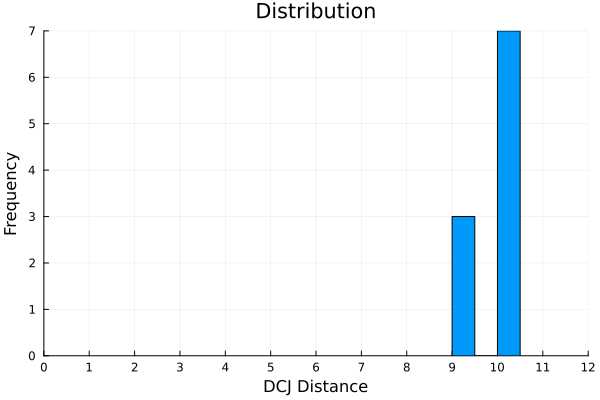

In [16]:
### visualization 

max_value = length(target)+2
println("max dcj distance = ", max_value)

# SOCS of distribution
# shape -- skewed right usually 
# outliers - none 
# center - depends 
# spread -- narrow 
min = minimum(dcj_dist_list)
max = maximum(dcj_dist_list)
avg = mean(dcj_dist_list)

println("min=", min)
println("max=", max)
println("avg=", avg)


# range for x-ticks from 0 to max_value with a step of 2
xticks = 0:1:max_value

# Create a histogram
histogram(dcj_dist_list, title="Distribution", label="", xlabel="DCJ Distance", ylabel="Frequency",  xlims=(0, max_value), xticks=(xticks, xticks))

